# Test and run offline eval for comparison to ground truth values

In [170]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.morphology import skeletonize
from skimage import img_as_ubyte

In [171]:
def skeleton(mask):
    skeleton = skeletonize(mask)
    return skeleton
    
def skeleton_length(mask):
    skeleton_length = np.sum(skeletonize(mask))
    return skeleton_length

def mask_area(mask):
    area = np.sum(mask)
    return area

In [229]:
def get_perpendicular_width(mask):
    skeleton_coords = np.column_stack(np.where(skeleton(mask)))
    widths = []
    
    for i, coord in enumerate(skeleton_coords):
        row, col = coord
        
        # Get the neighbors
        if i > 0 and i < len(skeleton_coords) - 1:
            prev_row, prev_col = skeleton_coords[i - 1]
            next_row, next_col = skeleton_coords[i + 1]
            
            # Calculate vector to neighbor
            skeleton_vector = np.array([next_row - prev_row, next_col - prev_col])
            skeleton_vector = skeleton_vector / np.linalg.norm(skeleton_vector)  # vector norm
            
            # Find a perpendicular direction and search along
            perpendicular_vector = np.array([-skeleton_vector[1], skeleton_vector[0]])
            left_dist = 0
            right_dist = 0

            while True: # search left
                new_row = int(row + left_dist * perpendicular_vector[0])
                new_col = int(col + left_dist * perpendicular_vector[1])
                
                if new_row < 0 or new_row >= mask.shape[0] or new_col < 0 or new_col >= mask.shape[1]:
                    break
                if mask[new_row, new_col] == 0:  # Stop when we hit the background
                    break
                left_dist += 1

            while True: # search right
                new_row = int(row + right_dist * perpendicular_vector[0])
                new_col = int(col + right_dist * perpendicular_vector[1])
                
                if new_row < 0 or new_row >= mask.shape[0] or new_col < 0 or new_col >= mask.shape[1]:
                    break
                if mask[new_row, new_col] == 0:  # Stop when we hit the background
                    break
                right_dist += 1
            
            # return total width at this point
            width = left_dist + right_dist
            widths.append(width)

    return widths


In [193]:
def process_biometrics(root_predictions, pred_files):
   
    data = []  # store rows for df

    for file in pred_files:
        mask_path = os.path.join(root_predictions, file) # full path 
        mask = Image.open(mask_path)
        mask = np.array(mask)

        skeleton_TL = skeleton_length(mask) # extract skeleton
        body_area = mask_area(mask) # extract body area
        widths = get_perpendicular_width(mask) # extract widths
        body_span = max(widths) if widths else 0 # extract span
        image_name = file.replace('pred_', '').replace('.png', '.JPG') # revert image name
        data.append((image_name, skeleton_TL, body_area, body_span)) # append tuple 
    
    df = pd.DataFrame(data, columns=['filename', 'skeleton_TL', 'body_area', 'body_span']) # construct df
        
    return(df)

In [194]:
# import predictions
root_predictions = '/home/Alexandra/Projects/bodycondition/sharkbody_seg/runs/unet_smp/split_crop/checkpoints/predictions'
pred_files = [f for f in os.listdir(root_predictions) if f.startswith("pred_")]
img_files = [f for f in os.listdir(root_predictions) if f.startswith("img_")]

# import metadata
metadata = '/mnt/class_data/group2/alexandradigiacomo/dataset/metadata/metadata.csv'
metadata_lengths = '/mnt/class_data/group2/alexandradigiacomo/dataset/metadata/sharklengths_metadata.csv' # photog lengths

# make dataframes
df_meta = pd.read_csv(metadata) # metadata from exif
df_meta_len = pd.read_csv(metadata_lengths) # measurements (photogrammetry)
df_meta_len.rename(columns={'FileName': 'filename'}, inplace=True)

# merge
df_meta_full = pd.merge(df_meta_len, df_meta, on=['filename', 'White.Shark.ID'], how='left')

In [195]:
# build skeleton df
df_skel = process_biometrics(root_predictions, pred_files)

In [196]:
# merge skeleton with metadata
merged_df = pd.merge(df_skel, df_meta_full, on='filename', how='left')

In [177]:
# build masks list
masks = []
for file in pred_files:
    mask_path = os.path.join(root_predictions, file)
    mask = Image.open(mask_path)
    mask = np.array(mask)
    masks.append(mask)  

# build image list
imgs = []
for file in img_files:
    img_path = os.path.join(root_predictions, file)
    img = Image.open(img_path)
    img = np.array(img)
    imgs.append(img)


Sanity check plot

In [178]:
mask = masks[7] # pull mask
skel_plot = skeleton(mask) # skeletonize mask

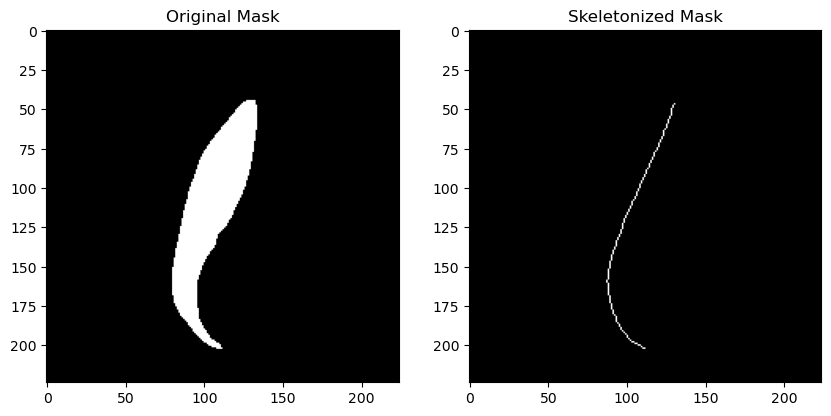

In [179]:
# Example plotting 
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Skeletonized Mask')
plt.imshow(skel_plot, cmap='gray')

plt.show()

Compute TLs and Compare

In [203]:
# create col with transf pixels (this is hard coded currently)
crop_size = 512
mask_size = 224 

merged_df['TL_pixels_skeleton_transf'] = merged_df['skeleton_TL'] * (crop_size / mask_size)

# Plotting

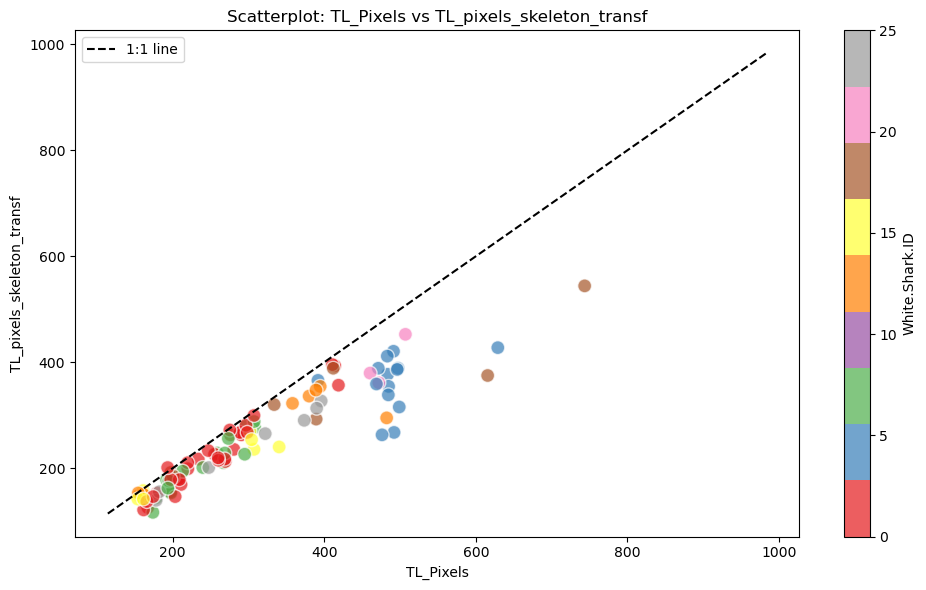

In [181]:
# Color TL:TL plot by White.Shark.ID
white_shark_id_mapping = {id_: idx for idx, id_ in enumerate(merged_df['White.Shark.ID'].unique())}
merged_df['White.Shark.ID_numeric'] = merged_df['White.Shark.ID'].map(white_shark_id_mapping)

# Create scatter plot with color mapping based on White.Shark.ID_numeric
plt.figure(figsize=(10, 6))

# Plot the scatter points, color by the numeric encoded White.Shark.ID
scatter = plt.scatter(merged_df['TL_Pixels'], merged_df['TL_pixels_skeleton_transf'],
                      c=merged_df['White.Shark.ID_numeric'], cmap='Set1', s=100, edgecolor='w', alpha=0.7)

# Plot the 1:1 line (where x = y)
min_val = min(merged_df['TL_Pixels'].min(), merged_df['TL_pixels_skeleton_transf'].min())
max_val = max(merged_df['TL_Pixels'].max(), merged_df['TL_pixels_skeleton_transf'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('TL_Pixels')
plt.ylabel('TL_pixels_skeleton_transf')
plt.title('Scatterplot: TL_Pixels vs TL_pixels_skeleton_transf')

# Add a colorbar and legend
plt.colorbar(scatter, label='White.Shark.ID')
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


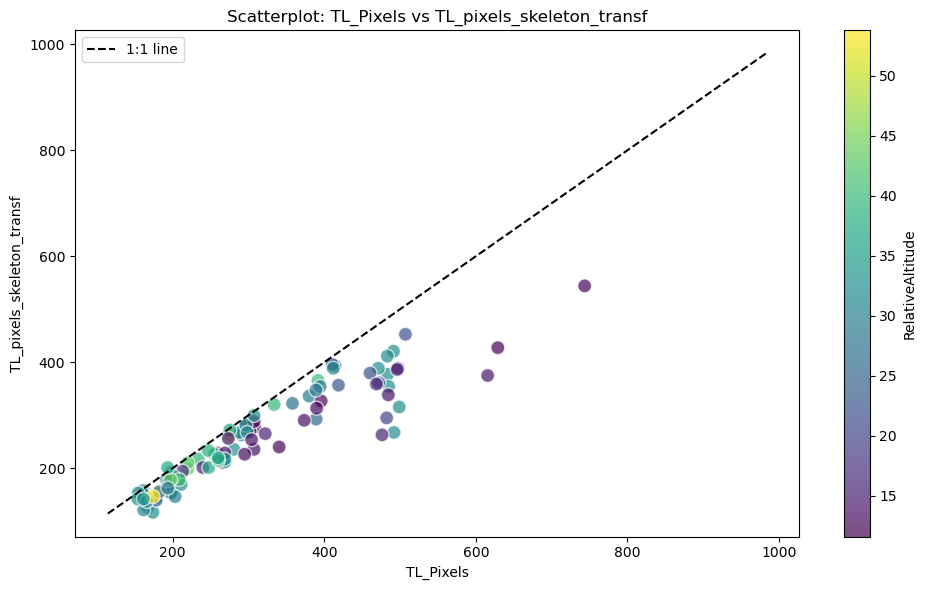

In [182]:
# Color TL:TL plot by relative altitude (cropping problem)
plt.figure(figsize=(10, 6))

# Plot the scatter points, color by 'RelativeAltitude'
scatter = plt.scatter(merged_df['TL_Pixels'], merged_df['TL_pixels_skeleton_transf'],
                      c=merged_df['RelativeAltitude_x'], cmap='viridis', s=100, edgecolor='w', alpha=0.7)

# Plot the 1:1 line (where x = y)
min_val = min(merged_df['TL_Pixels'].min(), merged_df['TL_pixels_skeleton_transf'].min())
max_val = max(merged_df['TL_Pixels'].max(), merged_df['TL_pixels_skeleton_transf'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('TL_Pixels')
plt.ylabel('TL_pixels_skeleton_transf')
plt.title('Scatterplot: TL_Pixels vs TL_pixels_skeleton_transf')

# Add a colorbar with the label for 'RelativeAltitude'
plt.colorbar(scatter, label='RelativeAltitude')

# Add a legend for the 1:1 line
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [183]:
# compute residuals from the 1:1 line
merged_df['abs_resid'] = (merged_df['TL_Pixels'] - merged_df['TL_pixels_skeleton_transf']).abs()

In [184]:
# most extreme differences
top_residuals = merged_df.nlargest(10, 'abs_resid')
top_residuals

,filename,skeleton_TL,body_area,body_span,Unnamed: 0,Label,TL_Pixels,White.Shark.ID,Nickname,TrueLength_ft,...,AbsoluteAltitude_y,RelativeAltitude_y,GimbalRollDegree,GimbalYawDegree,GimbalPitchDegree,site_y,date,TL_pixels_skeleton_transf,White.Shark.ID_numeric,abs_resid
50,12132023PAMB1002.JPG,164,1176825,48,480.0,shark,615.467,MB23121302_U_9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,374.857143,19,240.609857
42,10132023PAAN0105.JPG,117,1005210,42,271.0,shark,491.940,AN23101301_M_12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,267.428571,5,224.511429
84,10132023PAAN0104.JPG,115,994245,38,270.0,shark,476.123,AN23101301_M_12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.857143,5,213.265857
115,10132023PAAN0507.JPG,187,1851045,56,287.0,shark,628.892,AN23101304_U_U,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,427.428571,4,201.463429
149,12132023PAMB1003.JPG,238,1981095,60,481.0,shark,743.494,MB23121302_U_9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,544.000000,19,199.494000
168,10072023PAMB0306.JPG,129,1091910,44,214.0,shark,482.218,MB23100702_U_8.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,294.857143,12,187.360857
65,10132023PAAN0109.JPG,138,1054170,40,275.0,shark,498.800,AN23101301_M_12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.428571,5,183.371429
90,10132023PAAN0508.JPG,148,1020255,42,288.0,shark,484.410,AN23101304_U_U,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,338.285714,4,146.124286
26,10132023PAAN0107.JPG,155,1213800,38,273.0,shark,484.775,AN23101301_M_12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.285714,5,130.489286
63,09232023PAMB0603.JPG,158,1308915,42,194.0,shark,471.884,MB23092308_F_9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361.142857,20,110.741143


In [185]:
def plot_mask_and_skeleton(root_predictions, filename):
    # Step 1: Construct the mask filename based on the input filename
    mask_name = "pred_" + filename.replace(".JPG", ".png")  # Assuming masks are in .png format
    
    # Step 2: Find the path to the mask using the filename
    mask_path = os.path.join(root_predictions, mask_name)
    
    # Step 3: Load the mask image
    if os.path.exists(mask_path):
        mask = Image.open(mask_path)
        mask = np.array(mask)  # Convert to numpy array
        
        # Ensure it's binary (0 for background, 1 for object)
        mask = (mask > 128).astype(int)  # If mask contains values other than 0 and 1
        
        # Step 4: Skeletonize the mask
        skeleton = skeletonize(mask)

        # Step 5: Plot the original mask and skeletonized mask side by side
        plt.figure(figsize=(10, 5))

        # Original Mask Plot
        plt.subplot(1, 2, 1)
        plt.title('Original Mask')
        plt.imshow(mask, cmap='gray')
        plt.axis('off')  # Hide axes for cleaner look

        # Skeletonized Mask Plot
        plt.subplot(1, 2, 2)
        plt.title('Skeletonized Mask')
        plt.imshow(skeleton, cmap='gray')
        plt.axis('off')  # Hide axes for cleaner look

        plt.tight_layout()
        plt.show()
    else:
        print(f"Mask file {mask_name} not found in {root_predictions}")

plot_mask_and_skeleton(root_predictions, filename)


NameError: name 'filename' is not defined

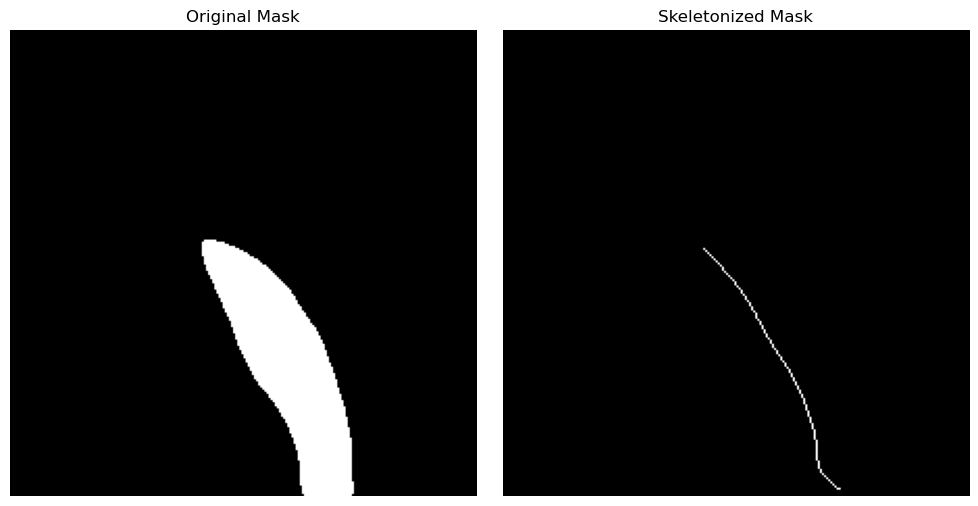

In [66]:
plot_mask_and_skeleton(root_predictions, '10132023PAAN0105.JPG')

# Photogrammetric Measurements Comparison

In [136]:
# perform photogrammetric conversions
gsd = merged_df['GSD_cm']
skel_pixt = merged_df['TL_pixels_skeleton_transf']
flight_transf = merged_df['Flight_Transformation']

merged_df['Uncalibrated_Skel_Length_cm'] = (skel_pixt*gsd) # transf w/o flight-based transf
merged_df['Calibrated_Skel_Length_cm'] = (skel_pixt*gsd)/flight_transf # transf w/flight-based transf

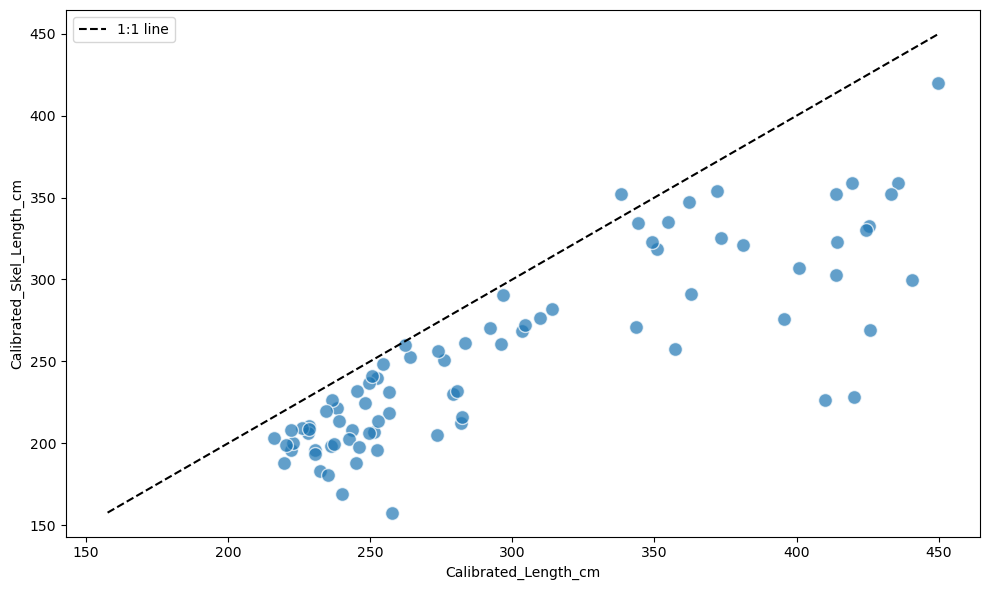

In [107]:
plt.figure(figsize=(10, 6))

scatter = plt.scatter(merged_df['Calibrated_Length_cm'], merged_df['Calibrated_Skel_Length_cm'],
                    s=100, edgecolor='w', alpha=0.7)

# Plot the 1:1 line (where x = y)
min_val = min(merged_df['Calibrated_Length_cm'].min(), merged_df['Calibrated_Skel_Length_cm'].min())
max_val = max(merged_df['Calibrated_Length_cm'].max(), merged_df['Calibrated_Skel_Length_cm'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('Calibrated_Length_cm')
plt.ylabel('Calibrated_Skel_Length_cm')

# Add a legend for the 1:1 line
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# comparison to visual length measurements; pull visual (ft) and convert to cm
ft_to_cm = 30.48
merged_df['VisualLength_cm'] = merged_df['White.Shark.ID'].apply(
    lambda x: float(x.split('_')[-1]) * ft_to_cm if isinstance(x, str) and x.count('_') >= 2 and x.split('_')[-1].isdigit() else None
)

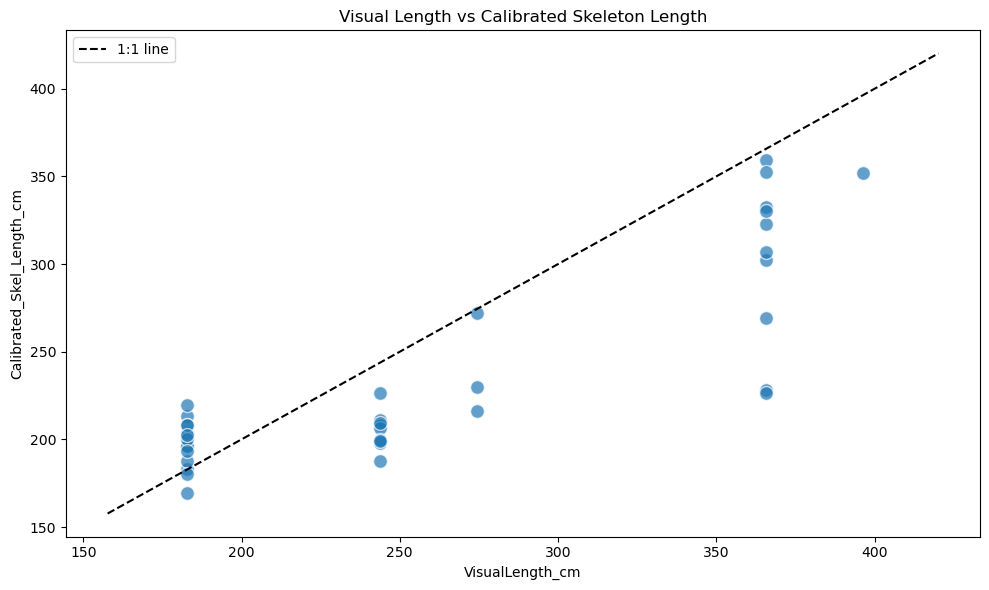

In [111]:
# Create a scatter plot with 'VisualLength_cm' vs 'Calibrated_Skel_Length_cm'
plt.figure(figsize=(10, 6))

scatter = plt.scatter(merged_df['VisualLength_cm'], merged_df['Calibrated_Skel_Length_cm'],
                      s=100, edgecolor='w', alpha=0.7)

# Plot the 1:1 line (where x = y)
min_val = min(merged_df['VisualLength_cm'].min(), merged_df['Calibrated_Skel_Length_cm'].min())
max_val = max(merged_df['VisualLength_cm'].max(), merged_df['Calibrated_Skel_Length_cm'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('VisualLength_cm')
plt.ylabel('Calibrated_Skel_Length_cm')
plt.title('Visual Length vs Calibrated Skeleton Length')

# Add a legend for the 1:1 line
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


# Body Condition Comparisons

In [315]:
# Find the coordinates of the skeleton
mask = masks[1] # choose an example mask

# pull out max width coords (**** to do here)
skeleton_coords = np.column_stack(np.where(skeleton(mask)))

# Get the widths at all skeleton points
widths = get_perpendicular_width(mask)

# Find the skeleton point with the maximum width
max_width_idx = np.argmax(widths)
max_width = widths[max_width_idx]
max_width_coord = skeleton_coords[max_width_idx]

TypeError: 'numpy.ndarray' object is not callable

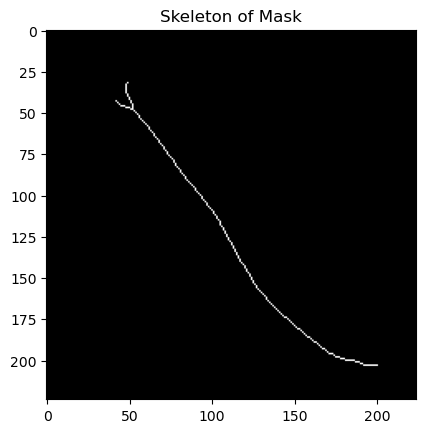

In [262]:
plt.imshow(skeleton(mask), cmap='gray')
plt.title("Skeleton of Mask")
plt.show()

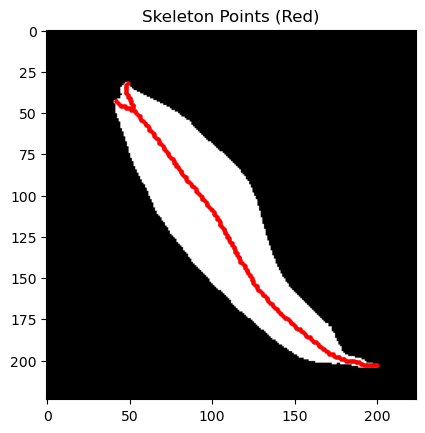

In [263]:
def visualize_skeleton(mask, skeleton_coords):
    plt.imshow(mask, cmap='gray')
    for coord in skeleton_coords:
        row, col = coord
        plt.scatter(col, row, color='red', s=5)  # Plot all skeleton points
    plt.title("Skeleton Points (Red)")
    plt.show()

# After computing skeleton_coords
visualize_skeleton(mask, skeleton_coords)


In [340]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import cv2

def get_skeleton(mask):
    """Get the skeleton of the mask."""
    return skeletonize(mask)

def get_outer_contour(mask):
    """Find the outer contour of the mask."""
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours[0]  # Get the largest contour

def smooth_skeleton(skeleton_coords, window_size=20):
    """Smooth the skeleton points by averaging nearby points."""
    smoothed_coords = []
    for i in range(1, len(skeleton_coords) - 1):
        # Get the window of neighboring points
        window = skeleton_coords[max(0, i - window_size // 2):min(len(skeleton_coords), i + window_size // 2 + 1)]
        
        # Compute the average of the window
        avg_row = np.mean(window[:, 0])
        avg_col = np.mean(window[:, 1])
        
        smoothed_coords.append([avg_row, avg_col])
    
    return np.array(smoothed_coords)

def draw_cross_sections_with_clip(mask, skeleton, num_sections=50, middle_percent=0.7, extend_factor=0.2):
    """Draw cross-sectional lines along the skeleton, clipped at the mask boundary."""
    skeleton_coords = np.column_stack(np.where(skeleton))  # Get skeleton points
    
    # Calculate the range for the middle 70% of the skeleton
    total_len = len(skeleton_coords)
    start_idx = int(total_len * (1 - middle_percent) / 2)
    end_idx = int(total_len * (1 + middle_percent) / 2)
    
    # Get the range of points to sample in the middle 70%
    skeleton_coords_middle = skeleton_coords[start_idx:end_idx]
    
    # Smooth the skeleton coordinates
    smoothed_skeleton_coords = smooth_skeleton(skeleton_coords_middle)

    # Ensure step size is at least 1 (avoid zero division)
    step_size = max(1, len(smoothed_skeleton_coords) // num_sections)
    
    cross_sections = []

    # Step through smoothed skeleton and compute cross-sectional lines
    for i in range(0, len(smoothed_skeleton_coords), step_size):
        row, col = smoothed_skeleton_coords[i]
        
        # Get the direction vector from the current skeleton point to the next one
        if i < len(smoothed_skeleton_coords) - 1:
            next_row, next_col = smoothed_skeleton_coords[i + 1]
        else:
            next_row, next_col = smoothed_skeleton_coords[i - 1]  # If last point, use the previous one
        
        # Direction vector from the current skeleton point to the next
        skeleton_vector = np.array([next_row - row, next_col - col], dtype=float)
        skeleton_vector /= np.linalg.norm(skeleton_vector)  # Normalize the vector

        # Get the direction vector from the previous skeleton point to the current one (for local tangent)
        if i > 0:
            prev_row, prev_col = smoothed_skeleton_coords[i - 1]
        else:
            prev_row, prev_col = smoothed_skeleton_coords[i]  # Use current point if it's the first

        # Local tangent (vector from previous point to next point)
        tangent_vector = np.array([next_row - prev_row, next_col - prev_col], dtype=float)
        tangent_vector /= np.linalg.norm(tangent_vector)  # Normalize tangent

        # Perpendicular vector to the skeleton (90 degrees rotation of the tangent)
        perp_vector = np.array([-tangent_vector[1], tangent_vector[0]])

        # Extend the perpendicular line by a larger factor (e.g., 20% of the mask size)
        left_dist = -extend_factor * min(mask.shape)  # Extend left by 20% of the mask size
        right_dist = extend_factor * min(mask.shape)  # Extend right by 20% of the mask size

        # Compute intersection points in both directions
        left_intersections = get_line_intersection((row, col), perp_vector, mask, max_len=left_dist)
        right_intersections = get_line_intersection((row, col), -perp_vector, mask, max_len=right_dist)

        # Add clipped cross-sections (endpoints of the intersections)
        if left_intersections and right_intersections:
            cross_sections.append((left_intersections[0], right_intersections[-1]))  # First and last points

    return cross_sections
      

def get_line_intersection(start_point, direction, mask, max_len=500):
    # Unpack starting point and direction
    row, col = start_point
    dr, dc = direction  # direction vector (row, col)

    # Ensure the direction vector is normalized
    norm = np.linalg.norm([dr, dc])
    dr, dc = dr / norm, dc / norm  # Normalize direction vector

    # Initialize list to store intersection points
    intersections = []
    
    # Move along the line in the given direction until we exceed the mask or reach the max_len
    for t in np.arange(0, max_len, 1):  # t is the step along the line
        new_row = int(row + t * dr)
        new_col = int(col + t * dc)

        if 0 <= new_row < mask.shape[0] and 0 <= new_col < mask.shape[1]:
            # Check the value at the current point
            if mask[new_row, new_col] == 0:  # If we hit background
                break  # End of line, stop extending
            intersections.append((new_row, new_col))
        else:
            break  # Stop if we're out of bounds
        
    return intersections



def visualize_cross_sections(mask, cross_sections):
    """Visualize the cross-sectional lines on the mask."""
    plt.imshow(mask, cmap='gray')
    
    # Plot each cross-sectional line
    for (left_row, left_col), (right_row, right_col) in cross_sections:
        plt.plot([left_col, right_col], [left_row, right_row], color='blue', linewidth=1)

    plt.title("Cross-Sectional Lines Along Skeleton (Middle 50%)")
    plt.show()

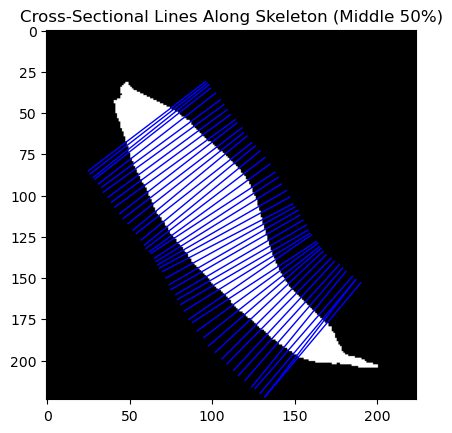

In [342]:

# Get the skeleton and outer contour of the mask
skeleton = get_skeleton(mask)
contour = get_outer_contour(mask)

# Draw the cross-sections along the middle 50% of the skeleton
cross_sections = draw_cross_sections_with_mask_boundary(mask, skeleton, num_sections=40, middle_percent=0.7, extend_factor=0.2)

# Visualize the cross-sections
visualize_cross_sections(mask, cross_sections)


Widest cross-section at skeleton point [110 109] with width 14 pixels.


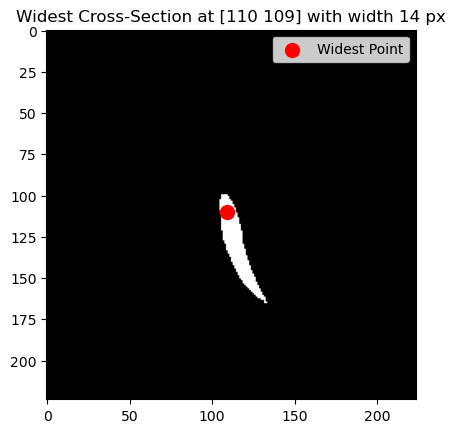

In [223]:
# Display the result
print(f"Widest cross-section at skeleton point {max_width_coord} with width {max_width} pixels.")

plt.imshow(mask, cmap='gray')
plt.scatter(max_width_coord[1], max_width_coord[0], color='red', label='Widest Point', s=100)
plt.legend()
plt.title(f"Widest Cross-Section at {max_width_coord} with width {max_width} px")
plt.show()

In [207]:
ls = merged_df['LateralSpan_Pixels']
fs = merged_df['FrontalSpan_Pixels']
ps = merged_df['ProximalSpan_Pixels']
tl = merged_df['TL_Pixels']

# manual BCR
merged_df['BCR'] = ((fs + ps + ls)/3)/tl

tl_skel = merged_df['TL_pixels_skeleton_transf']
body_area = merged_df['body_area']

# mask-based BAI
merged_df['BAI'] = (body_area/(tl_skel**2))*100

In [ ]:
# Set up the plot
plt.figure(figsize=(8, 6))

# Scatter plot for BCR vs. BAI
sns.scatterplot(data=merged_df, x='BCR', y='BAI', hue='site_x', alpha=0.7, palette='tab20')

# Adding labels and title
plt.title('BCR vs. BAI', fontsize=16)
plt.xlabel('BCR (Body Condition Ratio)', fontsize=12)
plt.ylabel('BAI (Body Area Index)', fontsize=12)

# take out high leverage pts
plt.xlim(right=0.19)

# Show the plot
plt.show()

In [204]:
bs = merged_df["body_span"] # mask body span
tl = merged_df["TL_pixels_skeleton_transf"] # mask length
merged_df["BSR_mask"] =  bs/tl

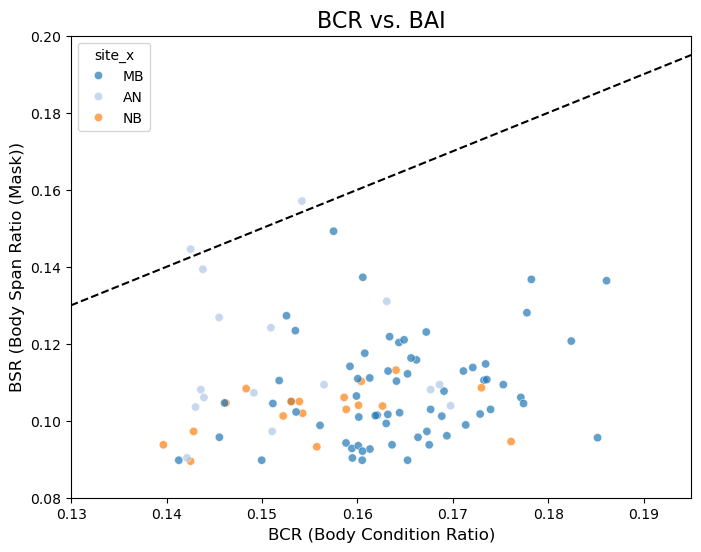

In [ ]:
# Set up the plot
plt.figure(figsize=(8, 6))

# Scatter plot for BCR vs. BAI
sns.scatterplot(data=merged_df, x='BCR', y='BSR_mask', hue='site_x', alpha=0.7, palette='tab20')

# Plot 1:1 line 
min_value = min(merged_df['BCR'].min(), merged_df['BSR_mask'].min())  # Determine the minimum value for the line
max_value = max(merged_df['BCR'].max(), merged_df['BSR_mask'].max())  # Determine the maximum value for the line

# Plot the 1:1 line
plt.plot([min_value, max_value], [min_value, max_value], color='black', linestyle='--', label='1:1 Line')

# Adding labels and title
plt.title('BCR vs. BAI', fontsize=16)
plt.xlabel('BCR (Body Condition Ratio)', fontsize=12)
plt.ylabel('BSR (Body Span Ratio (Mask))', fontsize=12)

# take out high leverage
plt.xlim(0.13, 0.195)
plt.ylim(0.08, 0.2)

# Show the plot
plt.show()